In [1]:
import polars as pl
import numpy as np
from pathlib import Path

In [2]:
RAW_DATA_PATH = '../data/raw/GUIDE_Train.parquet'
PROCESSED_FEATURES_V2_PATH = '../data/processed/incident_features.parquet'
FINAL_FEATURES_PATH = '../data/processed/incident_features_final.parquet'

# 1. Load Data
print(" Phase 5.1: Engineering the Final Feature Set")
raw_df = pl.scan_parquet(RAW_DATA_PATH)
incident_features_df = pl.read_parquet(PROCESSED_FEATURES_V2_PATH)


 Phase 5.1: Engineering the Final Feature Set


In [6]:
# 2. Top K DetectorId Feature Engineering
print("Engineering Top K DetectorId features...")
top_50_detectors = (
    raw_df.group_by('DetectorId')
          .agg(pl.len().alias('count'))
          .sort('count', descending=True)
          .head(50)
          .collect()['DetectorId']
          .to_list()
)

top_detector_feature = (
    raw_df.group_by('IncidentId')
          .agg(
              pl.col('DetectorId')
                .filter(pl.col('DetectorId').is_in(top_50_detectors))
                .len()
                .alias('top_50_detector_count')
          )
          .collect()
)


Engineering Top K DetectorId features...


In [ ]:
# B) Ratio Feature Engineering
print("Engineering ratio Features...")
ratio_feature = incident_features_df.with_columns(
    (pl.col('unique_alert_count') / pl.col('evidence_count')).alias('alerts_per_evidence_ratio')
).select(['IncidentId', 'alerts_per_evidence_ratio'])

# C) Time based "Burstiness" Feature
print("Engieering time based 'Burstiness' feature...")
burstiness_feature = (
    raw_df.with_columns(
        pl.col("Timestamp").str.to_datetime(time_zone="UTC")  
    )
    .group_by("IncidentId")
    .agg(
        pl.col("Timestamp").std().alias("timestamp_std_dev")
    )
    .collect()
)


Engineering ratio Features...
Engieering time based 'Burstiness' feature...


In [9]:
# 3 Join all new features into the final dataset
print("Joining all features to create the final dataset...")

final_df = incident_features_df.join(top_detector_feature, on='IncidentId', how='left')
final_df = final_df.join(ratio_feature, on='IncidentId', how='left')
final_df = final_df.join(burstiness_feature, on='IncidentId', how='left')

final_df = final_df.fill_null(0)

Joining all features to create the final dataset...


In [10]:
final_df.write_parquet(FINAL_FEATURES_PATH)

print("Final Feature Set Creation Complete")
print("Shape of the final feature dataframe:", final_df.shape)
print("\nNew features added:", ['top_50_detector_count', 'alerts_per_evidence_ratio', 'timestamp_std_dev'])
print("\nExample of the final dataframe:")
print(final_df.head())

Final Feature Set Creation Complete
Shape of the final feature dataframe: (848829, 24)

New features added: ['top_50_detector_count', 'alerts_per_evidence_ratio', 'timestamp_std_dev']

Example of the final dataframe:
shape: (5, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ IncidentI ┆ IncidentG ┆ evidence_ ┆ unique_al ┆ … ┆ alert_rat ┆ top_50_de ┆ alerts_pe ┆ timestam │
│ d         ┆ rade      ┆ count     ┆ ert_count ┆   ┆ e         ┆ tector_co ┆ r_evidenc ┆ p_std_de │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ unt       ┆ e_ratio   ┆ v        │
│ i64       ┆ str       ┆ u32       ┆ u32       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ u32       ┆ f64       ┆ datetime │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ [μs,     │
│           ┆           ┆           ┆           ┆   ┆        

# Make the Champion Model! (LightGBM)

In [18]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [19]:
FINAL_FEATURES_PATH = '../data/processed/incident_features_final.parquet'
df_final = pd.read_parquet(FINAL_FEATURES_PATH)


In [ ]:
# 2. Data Cleaning and Deduplication
print(f"Original shape with potential duplicates: {df_final.shape}")
df_final.sort_values(['IncidentId', 'IncidentGrade'], inplace=True)
df_final.drop_duplicates(subset=['IncidentId'], keep='first', inplace=True)
print(f"Cleaned shape with unique incidents: {df_final.shape}")

#  3. Prepare Data for Modeling 
raw_df = pd.read_parquet('../data/raw/GUIDE_Train.parquet', columns=['IncidentId', 'OrgId'])
raw_df.drop_duplicates(subset=['IncidentId'], keep='first', inplace=True)
df_final = pd.merge(df_final, raw_df, on='IncidentId', how='left')

if 'timestamp_std_dev' in df_final.columns:
    df_final['timestamp_std_dev'] = df_final['timestamp_std_dev'].apply(
        lambda x: x.total_seconds() if pd.notnull(x) else 0
    )


Original shape with potential duplicates: (448901, 25)
Cleaned shape with unique incidents: (448901, 25)


In [ ]:
print("Columns in df_final:")
print(df_final.columns.tolist())
print(f"Shape: {df_final.shape}")

print("\nChecking if OrgId merge worked:")
raw_df = pd.read_parquet('../data/raw/GUIDE_Train.parquet', columns=['IncidentId', 'OrgId'])
print(f"Raw data shape: {raw_df.shape}")
print(f"Raw data columns: {raw_df.columns.tolist()}")

print(f"Common IncidentIds: {len(set(df_final['IncidentId']).intersection(set(raw_df['IncidentId'])))}")
print(f"df_final unique IncidentIds: {df_final['IncidentId'].nunique()}")
print(f"raw_df unique IncidentIds: {raw_df['IncidentId'].nunique()}")


Columns in df_final:
['IncidentId', 'IncidentGrade', 'evidence_count', 'unique_alert_count', 'unique_entity_type_count', 'unique_detector_id_count', 'unique_mitre_techniques_count', 'unique_org_id_count', 'incident_duration_seconds', 'entity_Ip_count', 'entity_User_count', 'entity_MailMessage_count', 'entity_Machine_count', 'entity_File_count', 'category_InitialAccess_count', 'category_Exfiltration_count', 'category_SuspiciousActivity_count', 'category_CommandAndControl_count', 'category_Impact_count', 'evidence_rate', 'alert_rate', 'top_50_detector_count', 'alerts_per_evidence_ratio', 'timestamp_std_dev', 'OrgId_x', 'OrgId_y']
Shape: (448901, 26)

Checking if OrgId merge worked:
Raw data shape: (9516837, 2)
Raw data columns: ['IncidentId', 'OrgId']
Common IncidentIds: 448901
df_final unique IncidentIds: 448901
raw_df unique IncidentIds: 466151


In [ ]:
print("OrgId_x null count:", df_final['OrgId_x'].isnull().sum())
print("OrgId_y null count:", df_final['OrgId_y'].isnull().sum())
print("OrgId_x unique values:", df_final['OrgId_x'].nunique())
print("OrgId_y unique values:", df_final['OrgId_y'].nunique())

if 'OrgId_y' in df_final.columns:
    df_final['OrgId'] = df_final['OrgId_y'].fillna(df_final['OrgId_x'])
else:
    df_final['OrgId'] = df_final['OrgId_x']

df_final.drop(columns=['OrgId_x', 'OrgId_y'], inplace=True)

print(f"Final OrgId null count: {df_final['OrgId'].isnull().sum()}")
print(f"Final OrgId unique values: {df_final['OrgId'].nunique()}")

OrgId_x null count: 0
OrgId_y null count: 0
OrgId_x unique values: 4025
OrgId_y unique values: 4025
Final OrgId null count: 0
Final OrgId unique values: 4025


In [ ]:
TARGET = 'IncidentGrade'
features = [col for col in df_final.columns if col not in ['IncidentId', TARGET, 'OrgId']]
X = df_final[features]
y_raw = df_final[TARGET]
groups = df_final["OrgId"].fillna(0)  

le = LabelEncoder()
y = le.fit_transform(y_raw)
class_names = list(le.classes_)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Groups shape: {groups.shape}")
print(f"Target classes: {class_names}")
print(f"Number of unique groups (organizations): {groups.nunique()}")
print(f"Features: {features}")


Features shape: (448901, 22)
Target shape: (448901,)
Groups shape: (448901,)
Target classes: ['BenignPositive', 'FalsePositive', 'TruePositive']
Number of unique groups (organizations): 4025
Features: ['evidence_count', 'unique_alert_count', 'unique_entity_type_count', 'unique_detector_id_count', 'unique_mitre_techniques_count', 'unique_org_id_count', 'incident_duration_seconds', 'entity_Ip_count', 'entity_User_count', 'entity_MailMessage_count', 'entity_Machine_count', 'entity_File_count', 'category_InitialAccess_count', 'category_Exfiltration_count', 'category_SuspiciousActivity_count', 'category_CommandAndControl_count', 'category_Impact_count', 'evidence_rate', 'alert_rate', 'top_50_detector_count', 'alerts_per_evidence_ratio', 'timestamp_std_dev']


In [26]:
N_SPLITS = 5
cv = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
lgbm = lgb.LGBMClassifier(random_state=42, n_jobs=-1, objective='multiclass', class_weight='balanced')

oof_preds = np.zeros((len(df_final), len(class_names)))
oof_labels = np.zeros(len(df_final))

In [27]:
print("Retraining LightLGB on Final Feature Set")

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"FOLD {fold+1}/{N_SPLITS}")
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]

    lgbm.fit(X_train, y_train)
    val_preds_proba = lgbm.predict_proba(X_val)
    oof_preds[val_idx] = val_preds_proba
    oof_labels[val_idx] = y_val

# --- 5. Generate Final Results and Visuals ---
oof_class_preds = np.argmax(oof_preds, axis=1)


Retraining LightLGB on Final Feature Set
FOLD 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4280
[LightGBM] [Info] Number of data points in the train set: 287880, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
FOLD 2/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4325
[LightGBM] [Info] Number of data points in the train set: 368096, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info]

In [28]:
# A) Print the Final Classification Report
print("\nFinal LightGBM Performance (with Enhanced Features)")
final_f1_score = f1_score(oof_labels, oof_class_preds, average='macro')
print(f"Final Out-of-Fold Macro F1-Score: {final_f1_score:.5f}")
print("\nDetailed Classification Report:")
print(classification_report(oof_labels, oof_class_preds, target_names=class_names))



Final LightGBM Performance (with Enhanced Features)
Final Out-of-Fold Macro F1-Score: 0.59100

Detailed Classification Report:
                precision    recall  f1-score   support

BenignPositive       0.79      0.66      0.72    260495
 FalsePositive       0.64      0.54      0.59    116666
  TruePositive       0.36      0.66      0.46     71740

      accuracy                           0.63    448901
     macro avg       0.60      0.62      0.59    448901
  weighted avg       0.68      0.63      0.65    448901



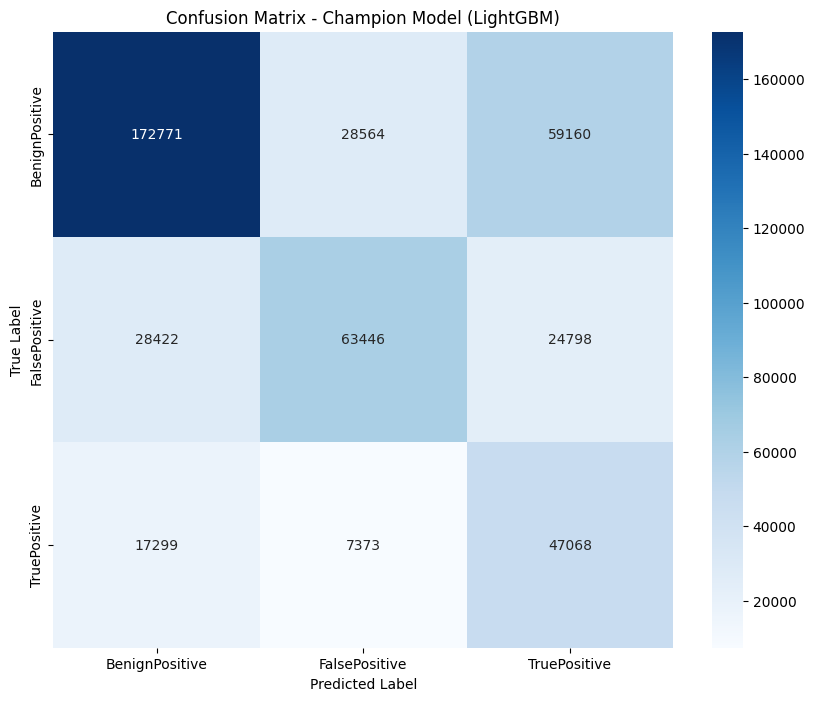

In [29]:
# B) Plot and Save the Confusion Matrix
cm = confusion_matrix(oof_labels, oof_class_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Champion Model (LightGBM)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('final_confusion_matrix.png')
plt.show()


# SHAP

In [ ]:
import shap
print("Training final LightGBM model for SHAP analysis...")
final_model = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    objective='multiclass',
    class_weight='balanced'
)
final_model.fit(X, y)

background = X.sample(n=min(1000, len(X)), random_state=42)

explainer = shap.TreeExplainer(final_model, data=background)

X_sample = X.sample(n=min(5000, len(X)), random_state=42)

shap_values = explainer(X_sample)  
print(f"Type of shap_values: {type(shap_values)}")



Training final LightGBM model for SHAP analysis...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4237
[LightGBM] [Info] Number of data points in the train set: 448901, number of used features: 21
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|===================| 14998/15000 [01:17<00:00]        

Type of shap_values: <class 'shap._explanation.Explanation'>


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

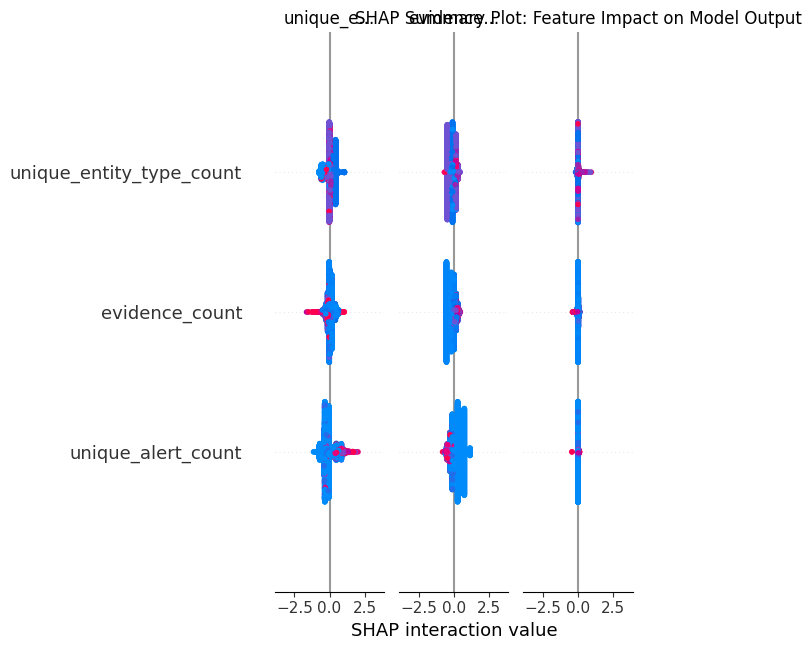

In [65]:
plt.figure(figsize=(10, 8))

# Check if shap_values is new Explanation object or old list
if isinstance(shap_values, list):
    shap.summary_plot(shap_values, X_sample, class_names=class_names, show=False)
else:
    # values shape: (n_samples, n_features, n_classes)
    shap.summary_plot(shap_values.values, X_sample, class_names=class_names, show=False)

plt.title("SHAP Summary Plot: Feature Impact on Model Output")
plt.tight_layout()
plt.savefig('shap_summary_plot.png')
plt.show()

<Figure size 1000x800 with 0 Axes>

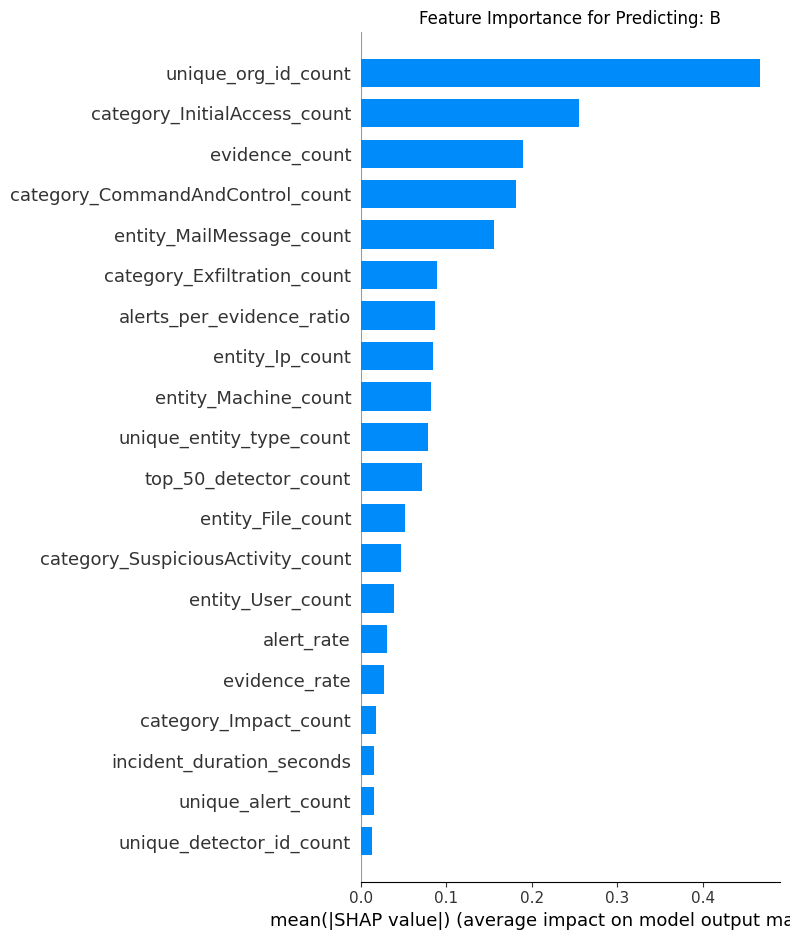

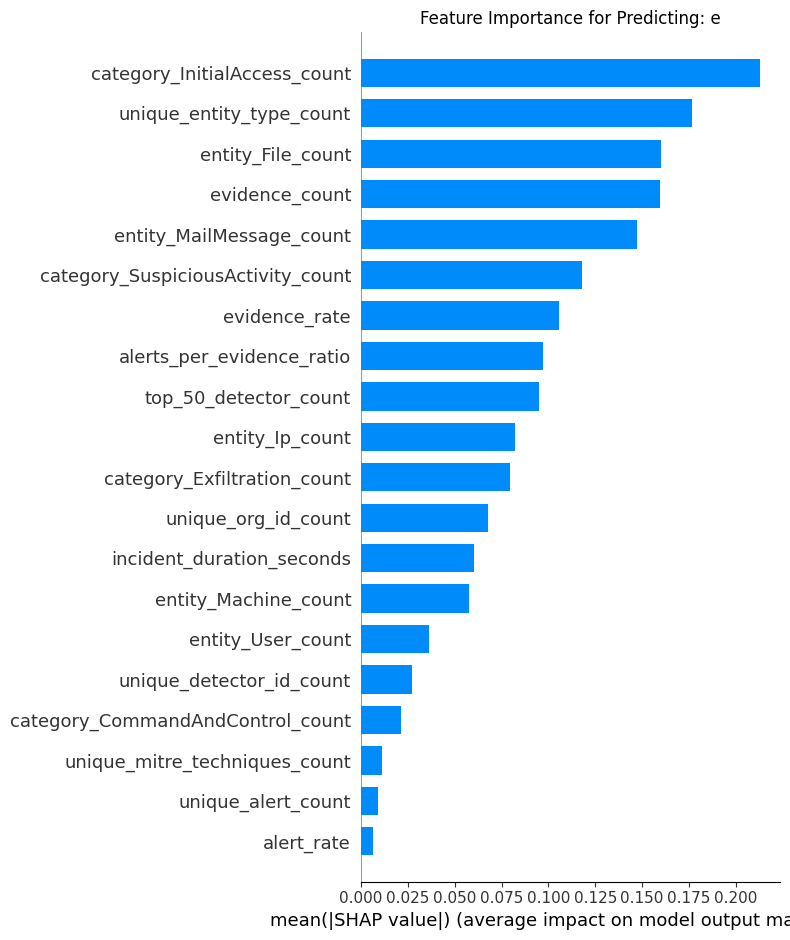

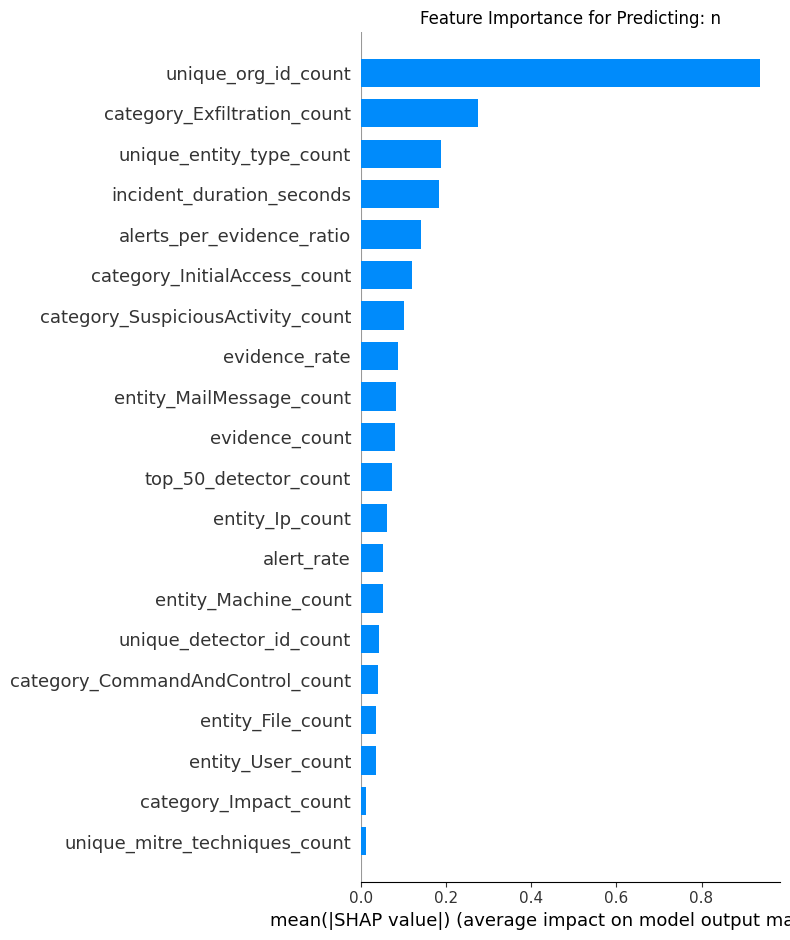

In [67]:
# Number of classes in the model
if isinstance(shap_values, list):
    n_classes = len(shap_values)
else:
    n_classes = shap_values.values.shape[2]

for i in range(n_classes):
    class_name = class_names[i] if i < len(class_names) else f"Class_{i}"
    plt.figure(figsize=(10, 8))
    
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[i], X_sample, plot_type='bar', show=False)
    else:
        shap.summary_plot(shap_values.values[:, :, i], X_sample, plot_type='bar', show=False)
    
    plt.title(f"Feature Importance for Predicting: {class_name}")
    plt.tight_layout()
    plt.savefig(f'shap_summary_{class_name}.png')
    plt.show()


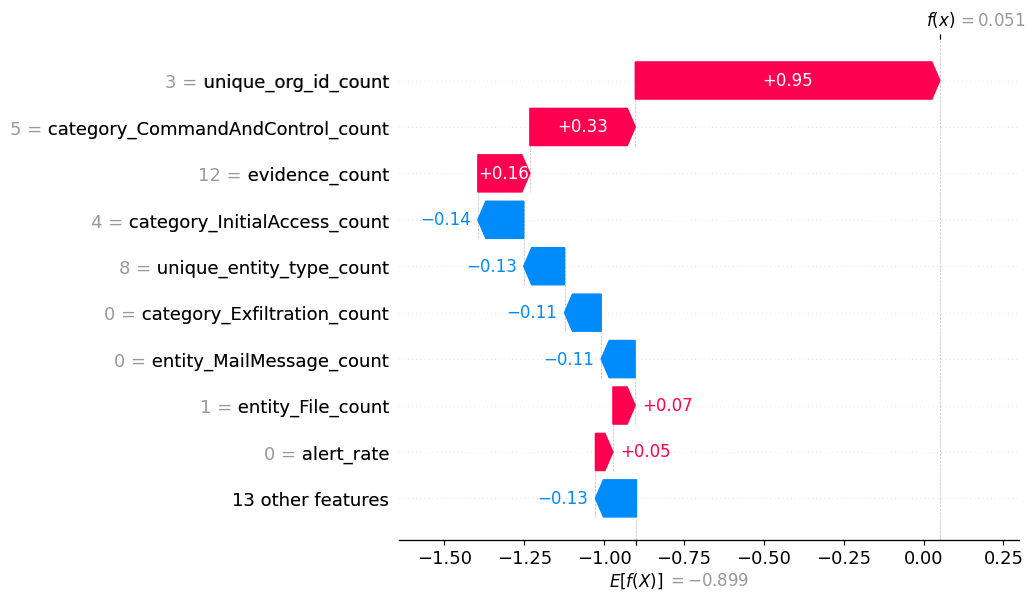

In [ ]:
sample_idx = 0  

class_idx = 0  
if isinstance(shap_values, list):
    shap_val = shap_values[class_idx][sample_idx]
else:
    shap_val = shap_values.values[sample_idx, :, class_idx]

shap.initjs()
shap.plots.waterfall(shap.Explanation(values=shap_val, 
                                      base_values=explainer.expected_value[class_idx],
                                      data=X_sample.iloc[sample_idx],
                                      feature_names=X_sample.columns))


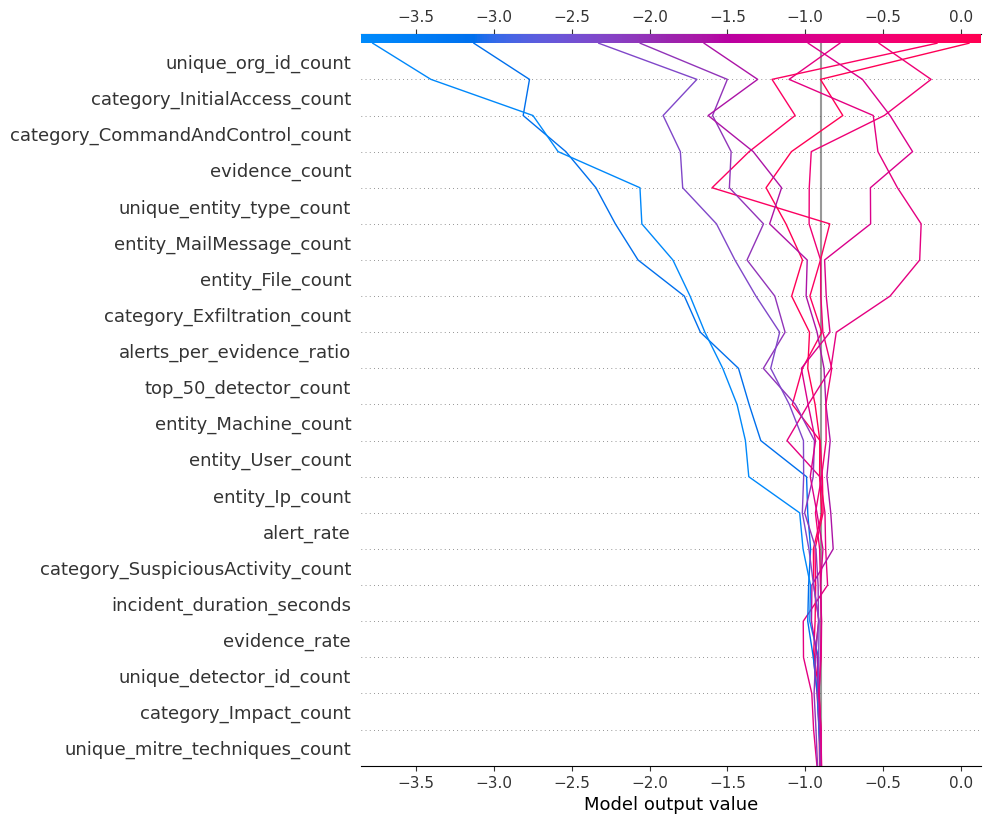

In [ ]:
sample_indices = range(10)  
class_idx = 0

if isinstance(shap_values, list):
    class_shap = shap_values[class_idx][sample_indices]
    base_value = explainer.expected_value[class_idx]
else:
    class_shap = shap_values.values[sample_indices, :, class_idx]
    base_value = explainer.expected_value[class_idx]

shap.decision_plot(base_value, class_shap, X_sample.iloc[sample_indices])
